# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
import warnings
import cmocean
import pyproj

warnings.filterwarnings("ignore")

%matplotlib inline

# Load data

In [2]:
grid = Grid.from_raster("../data/n30w100_con", data_name="dem")
grid.read_raster("../data/n30w100_dir", data_name="dir")

# Clip to a smaller grid

In [3]:
# N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Flowdir to angle mapping
mapping = {
    64: np.pi / 2,
    128: np.pi / 4,
    1: 0,
    2: 7 * np.pi / 4,
    4: 3 * np.pi / 2,
    8: 5 * np.pi / 4,
    16: np.pi,
    32: 3 * np.pi / 4,
    255: np.nan,
}

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(
    data="dir",
    x=x,
    y=y,
    dirmap=dirmap,
    out_name="catch",
    recursionlimit=15000,
    xytype="label",
    nodata_out=0,
)

# Clip the bounding box to the catchment
grid.clip_to("catch")
grid.resolve_flats("dem", out_name="inflated_dem")

# Compute flow directions

In [4]:
# Compute D8 flow directions
grid.flowdir("inflated_dem", dirmap=dirmap, routing="d8", out_name="d8_fdir")
# Compute D-infinity flow directions
grid.flowdir(
    "inflated_dem",
    dirmap=dirmap,
    routing="dinf",
    out_name="dinf_fdir",
    flats=np.nan,
    pits=np.nan,
)

In [5]:
d8_angle = (
    pd.Series(grid.view("d8_fdir", apply_mask=False, nodata=np.nan).ravel())
    .map(mapping)
    .values.reshape(grid.shape)
)
dinf_angle = grid.view("dinf_fdir", apply_mask=False)

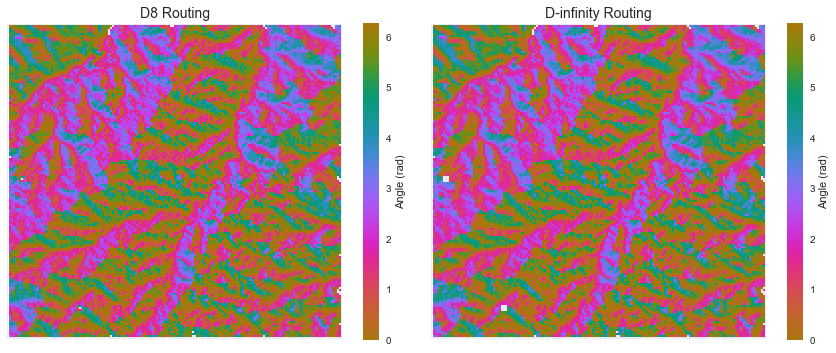

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.8))
im0 = ax[0].imshow(d8_angle, cmap=cmocean.cm.phase, vmin=0, vmax=2 * np.pi, zorder=1)
im1 = ax[1].imshow(dinf_angle, cmap=cmocean.cm.phase, vmin=0, vmax=2 * np.pi, zorder=1)
ax[0].xaxis.set_ticklabels([])
ax[1].xaxis.set_ticklabels([])
ax[0].yaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([])
ax[0].set_title("D8 Routing", size=14)
ax[1].set_title("D-infinity Routing", size=14)
plt.colorbar(im0, ax=ax[0], label="Angle (rad)")
plt.colorbar(im1, ax=ax[1], label="Angle (rad)")
plt.tight_layout()

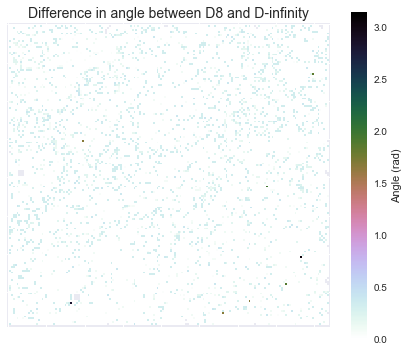

In [7]:
fig, ax = plt.subplots(figsize=(6, 5))
im0 = plt.imshow(
    np.arctan2(np.sin(dinf_angle - d8_angle), np.cos(dinf_angle - d8_angle)),
    vmin=0,
    vmax=np.pi,
    cmap="cubehelix_r",
    zorder=1,
)
ax.set_title("Difference in angle between D8 and D-infinity", size=14)
plt.colorbar(im0, ax=ax, label="Angle (rad)")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
plt.tight_layout()

# Delineate catchment

In [8]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(
    data="d8_fdir",
    x=x,
    y=y,
    out_name="d8_catch",
    recursionlimit=15000,
    xytype="label",
    routing="d8",
    nodata_out=0,
)

# Delineate the catchment
grid.catchment(
    data="dinf_fdir",
    x=x,
    y=y,
    out_name="dinf_catch",
    recursionlimit=15000,
    xytype="label",
    routing="dinf",
    nodata_out=np.nan,
)

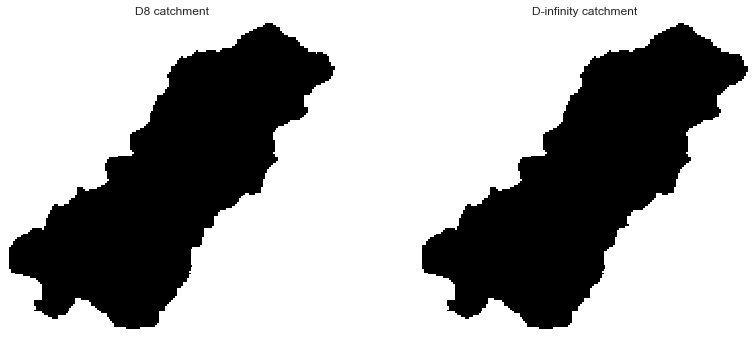

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.8))
ax[0].imshow(grid.view("d8_catch") > 0, zorder=1)
ax[1].imshow(~np.isnan(grid.view("dinf_catch")), zorder=1)
ax[0].xaxis.set_ticklabels([])
ax[1].xaxis.set_ticklabels([])
ax[0].yaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([])
ax[0].set_title("D8 catchment")
ax[1].set_title("D-infinity catchment")
plt.tight_layout()

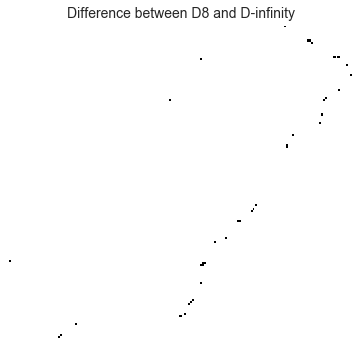

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.imshow(~np.isnan(grid.view("dinf_catch")) != (grid.view("d8_catch") > 0))
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_title("Difference between D8 and D-infinity", size=14)

# Compute accumulation

In [11]:
grid.accumulation("d8_fdir", routing="d8", dirmap=dirmap, out_name="d8_acc")
grid.accumulation("dinf_fdir", routing="dinf", dirmap=dirmap, out_name="dinf_acc")

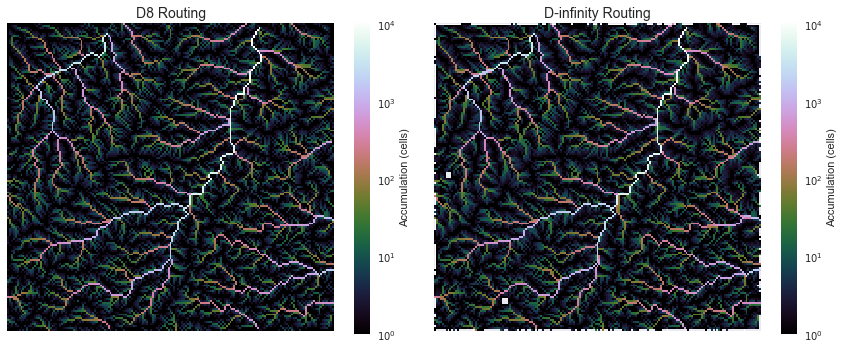

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.8))
im0 = ax[0].imshow(
    grid.view("d8_acc", apply_mask=False),
    cmap="cubehelix",
    norm=colors.LogNorm(vmin=1, vmax=grid.d8_acc.max()),
    zorder=1,
)
im1 = ax[1].imshow(
    grid.view("dinf_acc", apply_mask=False),
    cmap="cubehelix",
    norm=colors.LogNorm(vmin=1, vmax=grid.dinf_acc.max()),
    zorder=1,
)
ax[0].xaxis.set_ticklabels([])
ax[1].xaxis.set_ticklabels([])
ax[0].yaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([])
ax[0].set_title("D8 Routing", size=14)
ax[1].set_title("D-infinity Routing", size=14)
plt.colorbar(im0, ax=ax[0], label="Accumulation (cells)")
plt.colorbar(im1, ax=ax[1], label="Accumulation (cells)")
plt.tight_layout()

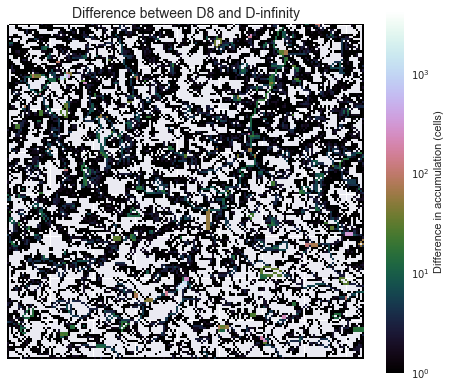

In [13]:
fig, ax = plt.subplots(figsize=(6.5, 5.5))

acc_diff = np.abs(grid.view("dinf_acc", apply_mask=False) - grid.view("d8_acc", apply_mask=False))
im0 = ax.imshow(
    acc_diff,
    norm=colors.LogNorm(vmin=1, vmax=acc_diff.max()),
    cmap="cubehelix",
    zorder=1,
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_title("Difference between D8 and D-infinity", size=14)
plt.colorbar(im0, label="Difference in accumulation (cells)")
plt.tight_layout()

# Compute flow distance (shortest path)

In [14]:
grid.flow_distance(
    x,
    y,
    "d8_fdir",
    routing="d8",
    xytype="label",
    dirmap=dirmap,
    out_name="d8_dist",
    nodata_out=np.nan,
    method="shortest",
)
grid.flow_distance(
    x,
    y,
    "dinf_fdir",
    routing="dinf",
    xytype="label",
    dirmap=dirmap,
    out_name="dinf_dist",
    nodata_out=np.nan,
    method="shortest",
)

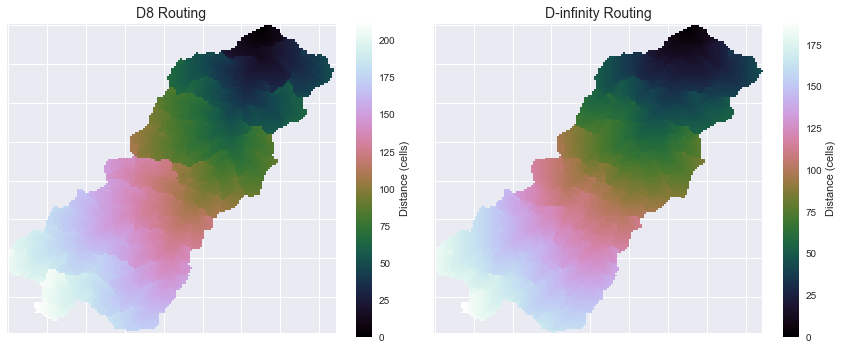

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.8))
im0 = ax[0].imshow(grid.view("d8_dist"), cmap="cubehelix", zorder=1)
im1 = ax[1].imshow(grid.view("dinf_dist"), cmap="cubehelix", zorder=1)
ax[0].xaxis.set_ticklabels([])
ax[1].xaxis.set_ticklabels([])
ax[0].yaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([])
ax[0].set_title("D8 Routing", size=14)
ax[1].set_title("D-infinity Routing", size=14)
plt.colorbar(im0, ax=ax[0], label="Distance (cells)")
plt.colorbar(im1, ax=ax[1], label="Distance (cells)")
plt.tight_layout()

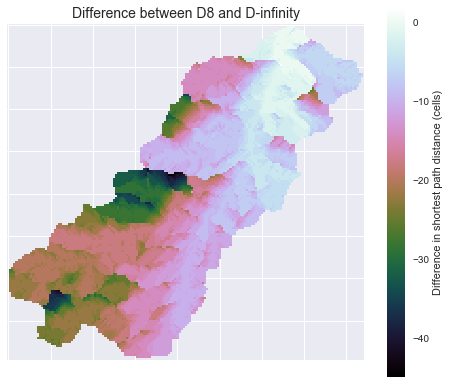

In [16]:
fig, ax = plt.subplots(figsize=(6.5, 5.5))

dist_diff = grid.view("dinf_dist") - grid.view("d8_dist")
im0 = ax.imshow(dist_diff, cmap="cubehelix", zorder=1)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_title("Difference between D8 and D-infinity", size=14)
plt.colorbar(im0, label="Difference in shortest path distance (cells)")
plt.tight_layout()